# Отчет по финальному проекту "Прогнозирование оттока клиентов"

** 2017/01/17**

*Юрий Исаков*

## 1. Введение
Выстраивание взаимоотношений с клиентами (или customer relationship managmenet, CRM) является важным звеном в функционировании любого бизнеса. От того, насколько хорошо простроена работа с аудиторией зачастую зависит успех всей компании. В проекте рассматривается одна из наиболее актуальных задач из области CRM: прогнозирование оттока пользователей (churn prediction). Суть задачи заключается в заблаговременном нахождении сегмента пользователей, склонных через некоторый промежуток времени отказаться от использования некоторого продукта или услуги. Точное и своевременное нахождение таких пользователей позволяет эффективно бороться с их оттоком, например, выявлять причины оттока и принимать меры по удержанию клиентов. Эта задача актуальна для большинства организаций, оказывающих услуги в сегменте B2C и вдвойне актуальна в областях, где распространение услуги близко к отметке 100%.

Цель проекта - научиться находить пользователей, склонных к оттоку. Если научиться находить таких пользователей с достаточной точностью заблаговременно, то можно эффективно управлять оттоком: например, выявлять причины оттока; помогать пользователям, попавшим в группу риска, решать их проблемы и задачи; проводить кампании по удержанию.

В соответствии с целью, были поставлены следующие задачи: 
1. провести разведочный анализ данных и подготовить признаки для построения модели,
2. построить прогнозую вероятностную модель и рассчитать метрики ее качества,
3. оценить экономический эффект от внедрения модели.

## 2. Техническая часть

In [1]:
import pandas as pd
import numpy as np
import itertools
import xgboost as xgb

from sklearn import metrics
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as ss

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### 2.1 Исходные данные

Данные для работы были предоставлены французской телекоммуникационной компанией Orange. В задаче речь идет о клиентских данных, поэтому данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Он состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные.

In [2]:
train = pd.read_csv("data/orange_small_churn_train_data.csv")
train.loc[train['labels'] == -1, 'labels'] = 0
labels = train['labels'].copy()
test = pd.read_csv('data/orange_small_churn_test_data.csv')

# имена категориальных и числовых переменных
features_num = train.columns[1:191].tolist()
features_cat = train.columns[191:231].tolist()

# приводим типы
train[features_cat] = train[features_cat].astype(object)
test[features_cat] = test[features_cat].astype(object)

# среднее по выборке
baseline = labels.mean()

#### 2.1.1 Числовые переменные

Т.к. целевая переменная бинарная (классы не отток/отток), то не подойдет расчет корреляции Пирсона (или любой другой), поэтому посчитаем разность матожиданий признака для обоих классов целевой переменной. Распределения числовых признаков могут быть самыми разными (см. дальше), поэтому в качестве меры связанности целевой переменной и признака будет использоваться уровень значимости гипотезы о том, что распределения признака для обоих классов (целевой переменной) совпадают. Воспользовавшись критерием Манна-Уитни получим, что матожидания 28 признаков для обоих классов отличаются на уровне значимости 0.01:

In [3]:
# таблица разностей
diff_numeric = train.loc[labels == 1, features_num].mean() - train.loc[labels == 0, features_num].mean()

# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
p_values = list()
for i, feat in enumerate(features_num):
    label0 = train.loc[labels == 0, feat].dropna()
    label1 = train.loc[labels == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        p_value = stats.mannwhitneyu(label0, label1)[1]
    p_values.append(p_value)

# сохраним разности матожиданий и значимости в отдельный датафрейм. и сразу отсортируем.
mns_and_ps = pd.DataFrame({'mean_diff': diff_numeric, 'p_value': p_values}).sort_values('p_value')

# количество переменных, у которых статистически значимо различаются средние
sum(mns_and_ps['p_value'] < 0.01)

28

Графики плотности распределений первых 8 наиболее отличающихся признаков в зависимости от целевой переменной:

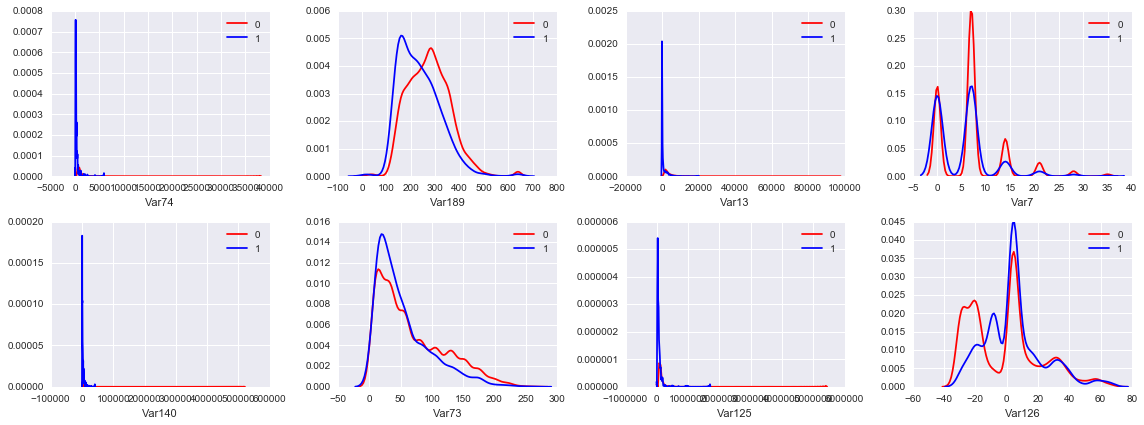

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i in range(8):
    sns.kdeplot(train.loc[labels == 0, mns_and_ps.index[i]], color = 'r', ax=axes[i / 4, i % 4], label=0)
    sns.kdeplot(train.loc[labels == 1, mns_and_ps.index[i]], color = 'b', ax=axes[i / 4, i % 4], label=1)
    axes[i / 4, i % 4].set(xlabel=mns_and_ps.index[i])
fig.tight_layout()

Числовые признаким имеют много пропусков, поэтому отсутствие значения в числовой переменной тоже может оказаться хорошим признаком для модели. На примере одного из предыдущих признаков, Var126, сравним доли положительного класса по всей выборке и среди пропущенных значений признака Var126:

In [5]:
print "Доля класса отток", baseline

print "Доля класса отток для пропущенных значений признака Var126:", np.round(labels[train.Var126.isnull()].mean(), 3)

Доля класса отток 0.0744
Доля класса отток для пропущенных значений признака Var126: 0.113


Можем убедиться, что доли различаются значимо, посчитав доверительный интервал Вильсона для доли пропущенных значений признака Var126:

In [6]:
proportion = labels[train.Var126.isnull()].mean() 
n = sum(train.Var126.isnull())
print "Доверительный интервал:", np.round(proportion_confint(proportion*n, n, alpha = 0.05, method="wilson"), 4)

Доверительный интервал: [ 0.1068  0.1185]


Таким образом, найдены кандидаты в признаки для моделей среди числовых переменных исходного датасета.

#### 2.1.2 Категориальные переменные

Категориальные переменные оказываются очень разные, они имеют от 1 (только пропущенное) до >13 тысяч уникальных значений. Чтобы проверить, какие из переменных могут оказаться для нас полезными поступим как с пропущенными значениями числовых признаков. Рассчитаем для каждого уникального значения категориальной переменной долю положительного класса и построим доверительный интервал для этой доли. Если доля исходного датасета остутствует в интервале, то этот признак (с этими уникальными значениями) может оказаться полезным для модели. 

На примере переменной Var229 рассчитаем доли:

In [7]:
# коэффициент корреляции Крамера для категориальных переменных
# http://stackoverflow.com/questions/20892799/using-pandas-calculate-cramérs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# обертка для функции выше
def get_cramers_cor(var1, var2):
    if var1.equals(var2):
        return 1.0
    confusion_matrix = pd.crosstab(var1, var2)
    return cramers_corrected_stat(np.array(confusion_matrix))

# строим доверительный интервал Вильсона (т.к. смещенные доли) и проверяем, принадлежит ли ему бейслайн
def in_conf_int(baseline, proportion, n, alpha = 0.05):
    conf_int = proportion_confint(proportion*n, n, alpha = alpha, method="wilson")
    # print baseline, conf_int
    if baseline > conf_int[0] and baseline < conf_int[1]:
        return True
    return False

In [8]:
# создадим временную таблицу
data = train.copy()
data['label'] = labels

# дадим шанс пропущенным значениям
data[features_cat] = data[features_cat].fillna('fakenan')

feat = 'Var229'
values = list(data[feat].unique())
props = list()
print "feature: " + feat
for val in values:
    sub_label = data.loc[data[feat] == val, 'label'] # целевая переменная только у выбранного значения
    conf_int = proportion_confint(np.mean(sub_label)*len(sub_label), len(sub_label), method="wilson")
    print "value: {0:12}".format(val) + "\tn: {0:6}".format(len(sub_label)) +\
        "\tprop: {0:.4f}".format(np.mean(sub_label)) +\
        "\t CI: [{0:.4f}, {1:.4f}]".format(conf_int[0], conf_int[1]) +\
        "\tbaseline in CI: {0}".format(in_conf_int(baseline, np.mean(sub_label), len(sub_label)))

feature: Var229
value: fakenan     	n:  22777	prop: 0.0886	 CI: [0.0850, 0.0924]	baseline in CI: False
value: mj86        	n:   7850	prop: 0.0550	 CI: [0.0502, 0.0603]	baseline in CI: False
value: am7c        	n:   9312	prop: 0.0561	 CI: [0.0516, 0.0609]	baseline in CI: False
value: oJmt        	n:     30	prop: 0.0667	 CI: [0.0185, 0.2132]	baseline in CI: True
value: sk2h        	n:     31	prop: 0.0323	 CI: [0.0057, 0.1619]	baseline in CI: True


Мы можем упростить себе поиск хороших категориальных признаков, если уменьшим их количество. 

Так встречаются признаки, у которых все значения пропущены.

А также мы можем уменьшить пространство поиска, если посчитаем взаимные корреляции среди категориальных переменных. Отобразим в виде тепловой карты корреляций (использовалась лишь часть переменных):

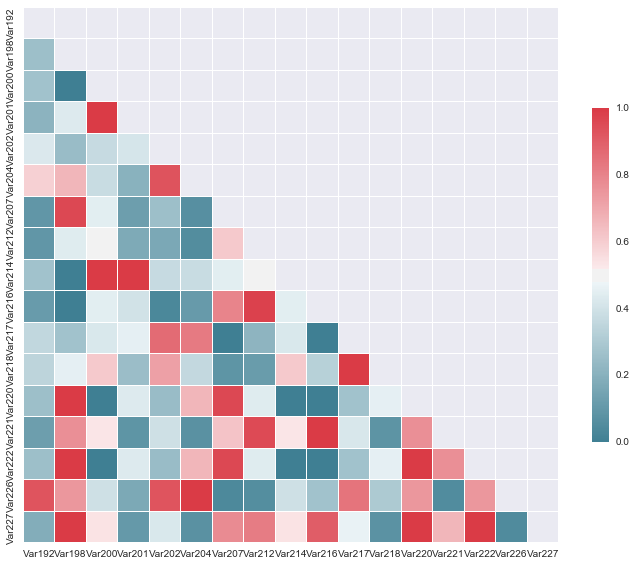

In [9]:
# рассматривать будет только эти категориальные переменные
features_cat_cor = ['Var192', 'Var198', 'Var200', 'Var201', 'Var202', 'Var204', 'Var207', 'Var212', 'Var214', 
                    'Var216', 'Var217', 'Var218', 'Var220', 'Var221', 'Var222', 'Var226', 'Var227']

# считаем корреляции
conf_matrix_cor = pd.DataFrame(1.0, index=features_cat_cor, columns=features_cat_cor)
for feat in itertools.combinations(features_cat_cor, 2):
    conf_matrix_cor.loc[feat[0], feat[1]] = get_cramers_cor(data[feat[0]], data[feat[1]])
    conf_matrix_cor.loc[feat[1], feat[0]] = conf_matrix_cor.loc[feat[0], feat[1]]

# маска треугольника
mask = np.zeros_like(conf_matrix_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# параметры графика
f, ax = plt.subplots(figsize=(12, 12))

# палитра
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# отрисовка тепловой карты
sns.heatmap(conf_matrix_cor, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

# удалим большую табличку
del data

Таким образом, выявлены кандидаты в признаки для модели среди категориальных переменных.

Перед использованием, категориальные признаки надо преобразовать в числа. Тут можно воспользоваться двумя вариантами: дамми-кодированием (по уникальному значению, т.е. дамми переменных будет количество уникальных значений - 1), либо посчитав долю положительного класса при каждом из уникальных значений, в этом случае будет одна новая числовая переменная. 

### 2.2 Подготовка признаков для модели

Этот раздел посвящен обработке признаков перед построением финальной модели. Очевидно, подбор признаков это процесс итеративный, поэтому здесь я постарался обойтись без кода, чтобы отчет выглядел лаконичнее.

#### 2.2.1 Работа с пропущенными значениями числовых и категориальных признаков

Как писалось выше, отсутствие значения у переменной можно рассматривать как новый категориальный признак. Для категориальных это делать необязательно, достаточно заменить все пропущенные значения каким-либо новым значением, которое раньше нигде не встречалось:

In [10]:
# создадим признак: пропущенно ли значение у числовых признаков
var_NA = train[features_num].isnull()
var_NA.columns = train[features_num].columns + ['_NA']

# для категориальных переменных проще
train[features_cat] = train[features_cat].fillna('fakenan') 
test[features_cat] = test[features_cat].fillna('fakenan') 

Тем не менее в самих числовых признаках надо заменить пропущенные значения на числа. Возможны, например, следующие варианты: замена на среднее, на медиану, на очень большое/маленькое число.

Как показало тестирование моделей, замена на медианы (вкупе с дамми-признаками пропущенных значений) показала несколько лучшие результаты, чем остальные варианты.

#### 2.2.2 Работа с категориальными признаками: замена на долю класса

Очень эффективным методом обработки категориальных признаков является такой, когда каждое значение заменяется долей положительного класса (при этом значении) -- target means (TM). Чтобы оценить насколько для данного наблюдения важен тот или иной признак, можно сравнить эту долю с общей по выборке (baseline), которая для исходного датасета равна $baseline = 0.0744$.

Однако не все признаки сгенерированные таким образом могут оказаться адекватными. Главная особенность состоит в том, что возможны редкие уникальные значения, которые встречаются всего лишь несколько раз за весь датасет (как упоминалось выше, есть признаки у которых >13 тысяч уникальных значений). И для таких редких значений доля может оказаться аномально высокой. Можно сделать поправку на частоту каждого из уникальных значений и посчитать скорректированную долю положительного класса (corrected target means, $TM_{cor} $:

$$ TM_{cor} = \frac{TM \cdot n + baseline \cdot \alpha}{n + \alpha}$$

Параметр сглаживаения $\alpha$ подбирается на кросс-валидации. 

Еще одним способом скорректировать доли является прореживание перед вычислением. Работает оно так:
```
1. Разбиваем обучающую выборку на k частей, i = 1
2. Для подвыборки i рассчитаются доли по подвыборкам 1,... i-1, i+1, ...k  и составляется таблица замен,
3. На основе категориального признака создается численный в соответствии с таблицей замен,
4. Пункты 2 и 3 повторяются для всех i = 1... k,
5. Для тестовой выборки доли считаются по всей обучающей выборке.
```

#### 2.2.3 Взаимодействия признаков, итеративный подбор

От того насколько удачно будут подобраны признаки, будет зависеть насколько хорошо модель будет строить прогнозы. Подбор признаков это последовательный процесс. В качестве финальной модели использовалась модель градиентного бустинга (xgboost) и в ней есть расчет важности признаков. От одной итерации к другой отбирались наиболее важные признаки и генерировались новые, которые снова отправлялись в модель. В зависимости от результатов признаким оставались, добавлялись и исключались.

Хорошим способом для новых признаков являются взаимодействия категориальных признаков. Для этого надо "слить" значения двух или более признаков (их символьных представлений). Для нового признака считаем доли как и для всех остальных категориальных признаков.

In [11]:
# переменные для взаимодействия
feat_cat_use = [] # список категориальных переменных для преобразования в доли


# трейн: замена сгенерированных значений вероятностью положительного класса по значениям
zebra = 4 # делим выборку на 4 подвыборки для прореживания
for feat in feat_cat_use:
    train_feat = np.array([np.nan] * train.shape[0])
    
    # чтобы не переобучиться, разбобьем выборку на несколько частей. тогда средние для первой части будут
    # вычисляться по 2, 3 и 4 и т.д.
    for i in range(zebra):
        idx_rplc = range(train.shape[0])[i::zebra]
        idx_tm = list(set(range(train.shape[0])) - set(idx_rplc))
        tm = train.ix[idx_tm, :].groupby([feat])['labels'].mean()
        train_feat[idx_rplc] = train.ix[idx_rplc, feat].map(tm)
    
    train[feat] = train_feat
    

# тест: замена сгенерированных значений вероятностью положительного класса по значениям
for feat in feat_cat_use:
    tm = train.groupby([feat])['labels'].mean()
    test[feat] = test[feat].map(tm)


# чего не встретилось заменим на общее среднее
train[feat_cat_use] = train[feat_cat_use].fillna(baseline)
test[feat_cat_use] = test[feat_cat_use].fillna(baseline)

Таким образом, подбор оптимальных признаков для модели выглядит так:

```
1: Первый датасет: числовые признаки (пропущенные значения заменены медианами), идикаторы пропущенных переменных в числовых признаках, доли, рассчитанные по исходным категориальным признакам;
2: Кросс-валидация на модели градиентного бустинга;
3: Оценка важности признаков;
4: Оставить важные признаки. Среди важных категориальных признаков сгенерировать новые как их взаимодействия. Слабые признаки убрать;
5: Повторить пункты 2-4 пока качество не перестанет расти;
6: Для уверенности выполнить все пункты на разных множествах исходных признаков.
```

Так были отобраны 150 признаков на которых градиентный бустинг показал наилучшие результаты. По названию переменных легко догадаться как были составлены признаки. Вот как выглядят несколько из наиболее важных признаков:

In [12]:
# https://github.com/yurkai/churn
imp_mat = pd.read_csv('data/imp_mat_150.csv')
imp_mat.head()

,Feature,Gain,Cover,Frequency,Importance
0,Var126,0.147104,0.182081,0.092999,0.147104
1,Var126_NAVar216Var218,0.051647,0.049470,0.017885,0.051647
2,Var126_NAVar205Var206,0.043041,0.041977,0.012775,0.043041
3,Var189,0.039173,0.049699,0.035258,0.039173
4,Var74,0.032791,0.030660,0.024527,0.032791


### 2.3 Построение модели

#### 2.3.1 Кросс-валидация без утечек

Наиболее важным моментом при построении модели является правильная кросс-валидация, которая необходима как для оценки гиперпараметрав, так и для оценки качества модели.

В нашем случае из-за особенностей признаков (доли) воспользоваться стандартными реализациями кросс-валидации. Проведем мысленный эксперимент. Когда мы отправляем данные на kaggle или получаем новый датасет, то мы составляем таблицу замен уникальных значений на соответствующие доли для категориальных признаков. Так же мы должны поступать и на кросс-валидации. Предположим мы разделили тренировочную выборку на 3 подвыборки (3 фолда), 1 первой подвыборке мы тестируем модель, а на 2 и 3 обучаем. В таком случаем мы должны рассчитывать доли для 1 фолда по таблицам замен, составленным из 2 и 3 подвыборок! В противном случае мы добавляем в 1 подвыборку утечку/информацию из будущего из-за чего получаем завышенное качество при тестировании. Из-за этой особенности придется делать собственную реализацию кросс-валидации  или пользоваться сторонними решениями, отказавшись от штатной возможности sklearn.

#### 2.3.2 Обучение модели


Загрузим подготовленные данные и обучим модель градиентного бустинга из библиотеки xgboost с гиперпараметрами, подобранными по кросс-валидации (приведены в коде):

In [13]:
# загрузим обработанный датасет, готовый для финальной модели
# https://github.com/yurkai/churn/blob/master/train_final_150.csv.zip
train = pd.read_csv('data/train_final_150.csv')
train.head()

,Var126,Var189,Var74,Var113,Var81,Var73,Var6,Var13,Var140,Var125,...,Var126_NAVar208Var212,Var204Var205,Var202Var229,Var206Var212Var217,Var206Var211,Var197Var228,Var208Var212Var218,Var126_NAVar199Var226,Var206Var208Var218,Var206Var212Var218
0,4,270,7,-1209960.0,14599.92,34,3052,232,220,6367.5,...,0.053551,0.041638,0.074400,0.0744,0.090888,0.074400,0.057288,0.067636,0.067888,0.064530
1,40,276,0,417932.0,67529.09,128,1813,636,205,24912.0,...,0.045832,0.051903,0.062000,0.0744,0.044863,0.037200,0.047369,0.046500,0.035707,0.038307
2,36,270,245,-124655.2,85266.00,166,1953,448,400,7218.0,...,0.027759,0.096640,0.067636,0.0744,0.046954,0.015434,0.031217,0.046500,0.051978,0.045895
3,4,270,0,378473.6,74107.20,30,1533,4,5,693.0,...,0.137896,0.076651,0.067636,0.0744,0.090888,0.106397,0.066087,0.074400,0.067888,0.070709
4,-28,270,0,142602.4,171072.90,32,686,0,225,468.0,...,0.074576,0.137239,0.074400,0.0744,0.104164,0.071672,0.075645,0.074400,0.082025,0.087700


In [14]:
# обучающая выборка для xgb
train_xgb = xgb.DMatrix(train.as_matrix(), labels)

# параметры обучения
param = {'eta': 0.03, 'subsample': 0.7, 'colsample_bytree': 1, 'scale_pos_weight': 5,
         'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight': 5, 'eval_metric': 'auc'}
evals = [(train_xgb, 'train')]

# обучим модель, будем выводить метрику на обучающей выборке
bst = xgb.train(param, train_xgb, num_boost_round = 351, verbose_eval = 50, evals = evals)

[0]	train-auc:0.691809
[50]	train-auc:0.752578
[100]	train-auc:0.769193
[150]	train-auc:0.781564
[200]	train-auc:0.792734
[250]	train-auc:0.802427
[300]	train-auc:0.811373
[350]	train-auc:0.819841


На момент написания этого отчета, модель построенная на основе таких признаков лидировала в соревновании на [kaggle](https://inclass.kaggle.com/c/telecom-clients-churn-prediction):

<img src=https://raw.githubusercontent.com/yurkai/churn/master/my_glory2.png>


## 3. Практическая часть

В этом разделе оценивается качество построенной модели и возможный экономический эффект от внедрения модели. Т.к. ответов для тестовой выборки не дано (и сама тестовая выборка очень мала), то все рассуждения будем строить на примере обучающей выборки. 

### 3.1 Качество модели

В соревновании на kaggle в качестве метрики взята ROC AUC. Для применения же важны и альтернативные метрики -- точность и полнота. Построим график точности от порога при достижении которого, мы считаем объект частью положительного класса:

In [15]:
# получим вероятности для исходных данных
y_fit = pd.Series(bst.predict(train_xgb), index=labels.index)

print "ROC AUC на обучающей выборке:", round(metrics.roc_auc_score(labels, y_fit), 2)

ROC AUC на обучающей выборке: 0.82


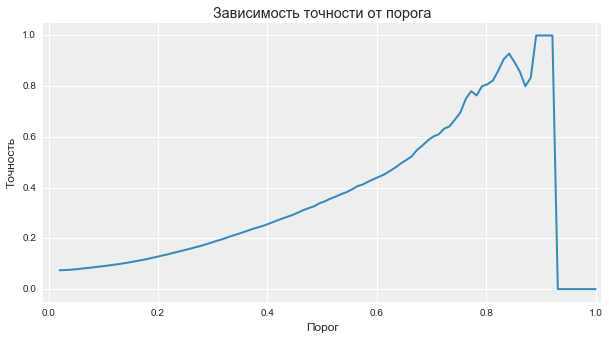

In [17]:
# рассчитаем точность в зависимости от порога
thrslds = np.linspace(0.02, 1, num=100)
prec = pd.Series([metrics.precision_score(labels, y_fit > thrsld) for thrsld in thrslds])

# отобразим график
plt.style.use('bmh')
f, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-0.01, 1.01]) 
plt.ylim([-0.05, 1.05]) 
plt.xlabel(u'Порог')
plt.ylabel(u'Точность')
plt.title(u'Зависимость точности от порога')
plt.plot(thrslds, prec)
plt.grid(True)
plt.show()

Посмотрим на график точности в зависимость от доли top% (т.е. отсортируем вероятности в порядке убывания и посчитаем точность для каждого значения доли объектов) и построим график этой зависимости:

In [17]:
# составим таблицу для расчета
prob = y_fit.sort_values(ascending=False)
prec = [1.0* sum(labels[prob.index][:i+1]) / (i+1)  for i in range(40000)]
probs = pd.DataFrame({'probability': y_fit.sort_values(ascending=False),
                     'label': labels[prob.index],
                     'proportion': np.linspace(0,1,40001)[-40000:],
                     'precision': prec})

probs[:10]

,label,precision,probability,proportion
33604,1,1.000000,0.921010,0.000025
26798,1,1.000000,0.907220,0.000050
14055,1,1.000000,0.897711,0.000075
437,1,1.000000,0.887902,0.000100
13251,1,1.000000,0.883899,0.000125
21309,0,0.833333,0.881381,0.000150
1363,1,0.857143,0.881035,0.000175
37549,0,0.750000,0.878670,0.000200
13318,1,0.777778,0.877845,0.000225
21363,1,0.800000,0.876597,0.000250


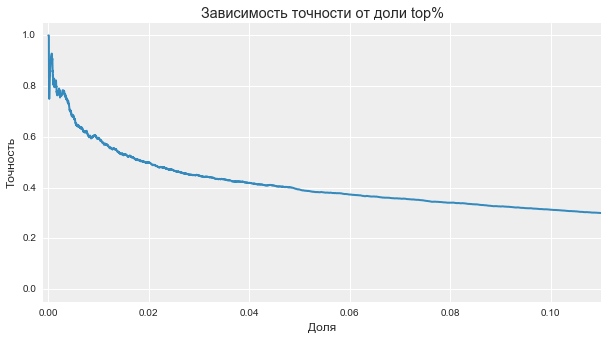

In [18]:
plt.style.use('bmh')
f, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-0.001, .11]) 
plt.ylim([-0.05, 1.05]) 
plt.xlabel(u'Доля')
plt.ylabel(u'Точность')
plt.title(u'Зависимость точности от доли top%')
plt.plot(probs.proportion, probs.precision)
plt.grid(True)
plt.show()

### 3.2 Экономический эффект

Рассмотрим экономически эффект от внедрения модели для гипотетической телекомуникационной компании. Т.к. никаких данных о ее размере и доходах предоставлено не было, придумаем эти данные сами. Точку опоры возьмем [по итогам](http://www.cnews.ru/news/top/2016-03-22_kto_bolshe_zarabotal_v_2015_g_mtsbilajn) работы тройки сотовых операторов за 2015 год. Средний доход с абонента составляет порядка 300 рублей. Тогда можно посчитать эффективность внедрения модели как разность между доходом с решившихся остаться абонентов и суммой, потраченной на удержание абонентов:

$$Доход = Доход_{абон}\cdot n_{ост}\cdot p_{ост} - Цена_{удерж}\cdot n_{удерж}, $$

где $n_{ост}$ -- количество абонентов, решивших принять преложение и остаться с вероятностью $p_{ост}$, а $n_{удерж}$ -- количество пользователей, которых мы хотим удержать, куда в силу неидеальности модели входят не только пользователи, склонные к оттоку, но и лояльные абоненты. Количество оставшихся абонентов рассчитывается как:
$$n_{ост}=precision \cdot top_{\%} \cdot n,$$ 
т.е. как произведение точности модели, доли удерживаемых абонентов и их общего числа.

Очевидно, не всем абонентам, которых мы считаем склонных к оттоку выгодно пытаться удержать. Для простоты положим в первой формуле вероятность удержания равной 1, т.к. реальная вероятность не известна, но для начала мы очень верим в наших маркетологов (реальная вероятность будет, конечно же, меньше, поэтому и доход уменьшится пропорционально). В этом случае оценим оптимальную долю абонентов, которым мы сделаем предложение:

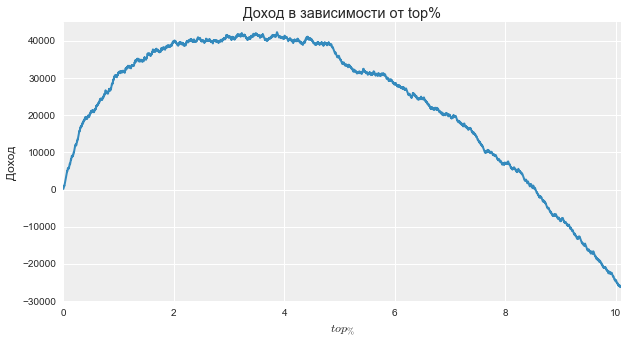

In [19]:
# рассчитаем доход для каждой возможной доли top% (здесь = proportion)
revenue = probs.copy()
n = 40000
arpu = 300
churn_price = 100
revenue['churners'] = revenue['precision'] * revenue['proportion'] * n
revenue['total'] = range(1, n+1)
revenue['diff'] = arpu * revenue['churners'] - churn_price * revenue['total']

plt.style.use('bmh')
f, ax = plt.subplots(figsize=(10, 5))
plt.xlim([-0.001, 10.10]) 
plt.ylim([-30000.05, 45000.05]) 
plt.xlabel(u'$top_{\%}$')
plt.ylabel(u'Доход')
plt.title(u'Доход в зависимости от top%')
plt.plot(revenue['proportion'] *100, revenue['diff'])
plt.grid(True)
plt.show()

Максимум дохода достигается при top% ~ 4%  Таким образом, можно вернуть порядка 40 тысяч рублей из упущенной выгоды применив модель и вычислив абонентов, склонных расторгнуть контракт с компанией.

Теперь оценим насколько выгодно дорабатывать модель и повышать точность выявления проблемных абонентов. Зафиксируем основные значения:

In [20]:
revenue.loc[revenue.proportion == 0.04]

,label,precision,probability,proportion,churners,total,diff
37687,1,0.41875,0.578867,0.04,670.0,1600,41000.0


Для доли 0.04: $top_{\%}=4\%, precision=0.41875$ и доход составляет 41 тысячу рублей. Пусть удается повысить точность модели на 2%, что обойдется компании в 20 тысяч, в этом случае доход составит:

In [21]:
print "Доход при увеличении точности на 2%:", (0.41875 + 0.02) * 0.04 * n * arpu - 0.04 * n * churn_price - 20000

Доход при увеличении точности на 2%: 30600.0


При таком раскладе оказывается не очень выгодно вести исследования и улучшать модель, доход упал на 10 тысяч. Стоит вспомнить, что этот расчет основывается на том, что всего 40 000 абонентов. Если представить, например, что абонентская база у телекомуникационной компании составляет 400 000 в типичной области при населении ~2 млн человек, то цифры окажутся другими:

In [22]:
# 400 000 абонентов
n=400000
print "Доход исходной модели:", 0.41875 * 0.04 * n * arpu - 0.04 * n * churn_price
print "Доход при увеличении точности на 2%:", (0.41875 + 0.02) * 0.04 * n * arpu - 0.04 * n * churn_price - 20000


Доход исходной модели: 410000.0
Доход при увеличении точности на 2%: 486000.0


В этом случае исследования полностью себя оправдывают. 

Итак, для получения адекватных результатов необходима тонкая настройка не только прогнозной, но и экономической модели, т.к. может оказаться что в зависимости от ситуации -- количества абонентов, уровня оттока, эффективности предложения (остаться) и т.д. выгода может существенно различаться.

### 3.3 Об идеях внедрения модели

Как писалось выше, использование прогнозной модели может оказаться экономически выгодным. Однако, на практике все оказывается по-другому, чем представлялось заранее. Поэтому хотелось бы поделиться некоторыми общими соображениями по поводу внедрения и использования модели:

1. "Средний" абонент. При построении прогнозной модели все пользователи усреднялись. Без сомнений, это весьма грубое допущение, потому как потребности у абонентов разные. Например, у кого-то может быть в приоритете стоимость сообщений, у кого-то интернет для планшета на дополнительном номере, а для кого-то важна бесперебойная связь в роуминге. Поэтому каждому надо делать предложение, которое может заинтересовать именно его, а не "среднего" абонента. Отсюда вывод о необходимости сегнментации абонентов (к счастью, не только для использования модели, а вообще для понимания поведения абонентов);

2. A/A тестирование. При наличии достаточного количества данных можно провести А/А тестирование бесплатно и узнать, например, как сильно могут отличаться доли в двух группах абонентов, которым мы не делаем никакого предложения. Если результаты существенно различаются, то, вероятно, мы плохо разбиваем пользователей на группы или упускаем что-то еще;

3. Разбиение пользователей для A/B тестирования. Здесь кажется логичным делать стратифицированные разбиения. Например, отобраны top% абонентов 1, 3, 5, ... абоненты попадут в группу A, а 2, 4, 6, ... абоненты попадут в группу B. Здесь мы полагаем эту выборку стратифицированной основываясь на результатах прогнозной модели (сначала идут те абоненты, предсказанная вероятность для которых больше). Однако, свои изменения могут внести сегментация, свежесть модели и прочее;

4. Профиль пользователя. Для каждого абонента можно анализировать историю звонков, ведь кто-то может пользоваться услугами преимущественно в рабочее время или наоборот. Так же, может оказаться полезным вычислять местоположение абонента, что тоже расскажет об абоненте и т.д. Профилирование и сегментация могут взаимно дополнять друг друга (и, вообще говоря, грань между ними может быть условной);

5. Наблюдение за ключевыми параметрами. Построить и использовать модель может оказаться полезным и выгодным делом, но, скорее всего, она не будет вечной. Поэтому периодически необходимо проверять как модель работает, как она описывает отток пользователей, постепенно набирая статистику как бизнес-показателей, так и метрик модели. Получая все больше и больше новых данных можно дообучать модель, выявлять ее слабые и сильные стороны;

6. Выявление ошибок классификации. Для объектов, где модель ошибается сильно можно найти наиболее близкие (например, использовать косинусную меру) и попытаться выявить, что приводит к ошибке. Однако, может оказаться, что эти объекты аномальные и нет разумных объяснений, почему допускается ошибка. В этом случае, можно разметить дополнительный признак;

7. Обновление модели. Рано или поздно настанет момент, когда модель перестанет давать заявленое качество. Это может быть вызвано разными измнениями: ситуация на рынке, новые предложения компании и т.д. Поэтому необязательно дожидаться падения метрик модели, если в работе компании произошли или планируются перемены.

## 4. Заключение

Были проанализированы данные компании Orange и составлена вероятностная модель прогнозирования оттока клиентов. Модель использует исходные числовые данные, а также двойные и тройные взаимодействия категориальных признаков, переведенные  в числовые как доли положительного класса. Для построения использовалась модель градиентного бустинга (xgboost). Сделана оценка качества модели. Проведен расчет экономической эффективности модели, показаны условия, когда она может быть прибыльной, а так же высказаны идеи и предположения об ее внедрении и эксплуатации.